In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-08-29 01:12:50.273719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 01:12:50.273767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [6]:
data_train = pd.read_csv('./WADI/data2019_train.csv', index_col=[0], parse_dates=True)
display(data_train.head())

data_test = pd.read_csv('./WADI/data2019_test.csv', index_col=[0], parse_dates=True)
data_test = data_test.rename(columns={'Attack LABLE (1:No Attack, -1:Attack)': 'anomaly'})

display(data_test.head())

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
2017-09-25 18:00:01,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:02,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:03,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:04,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68
2017-09-25 18:00:05,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68


,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
2017-10-09 18:00:01,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09 18:00:02,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09 18:00:03,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09 18:00:04,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
2017-10-09 18:00:05,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1


In [7]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index(['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS'], dtype='object')

deleting constant features: ['1_LS_001_AL', '1_LS_002_AL', '1_P_002_STATUS', '1_P_004_STATUS', '2_MV_001_STATUS', '2_MV_002_STATUS', '2_MV_004_STATUS', '2_MV_005_STATUS', '2_MV_009_STATUS', '2_P_004_STATUS', '2_SV_101_STATUS', '2_SV_201_STATUS', '2_SV_301_STATUS', '2_SV_401_STATUS', '2_SV_501_STATUS', '2_SV_601_STATUS', '3_LS_001_AL', '3_MV_001_STATUS', '3_MV_002_STATUS', '3_MV_003_STATUS', '3_P_001_STATUS', '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS', 'PLANT_START_STOP_LOG']


In [8]:
bad_col = ['3_AIT_002_PV', '2B_AIT_002_PV']

In [9]:
summary = {}

## Подготовка train/test

In [18]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)


Standard scaler 
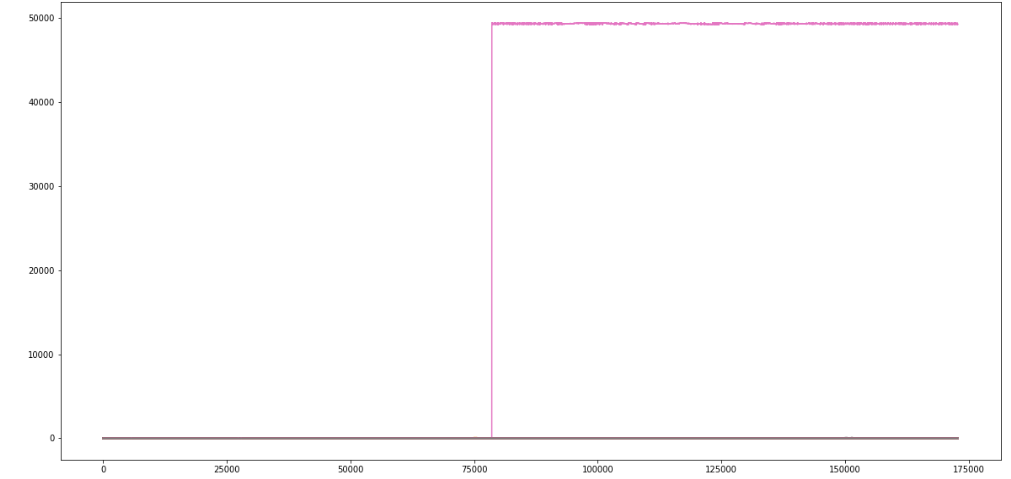

MinMax scaler
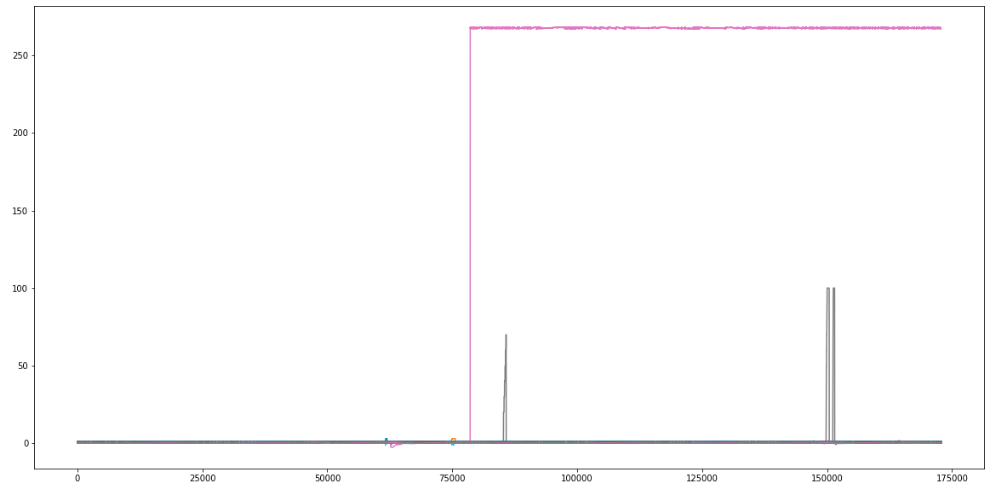

## OC SVM

In [19]:
description='WADI_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-08-28 20:37:46.044496: find saved model: ./saved_models/WADI_svm_default.joblib, loading...


WADI_svm_default
f1_score: 0.10
accuracy_score: 0.45
precision_score: 0.05
recall_score: 0.51


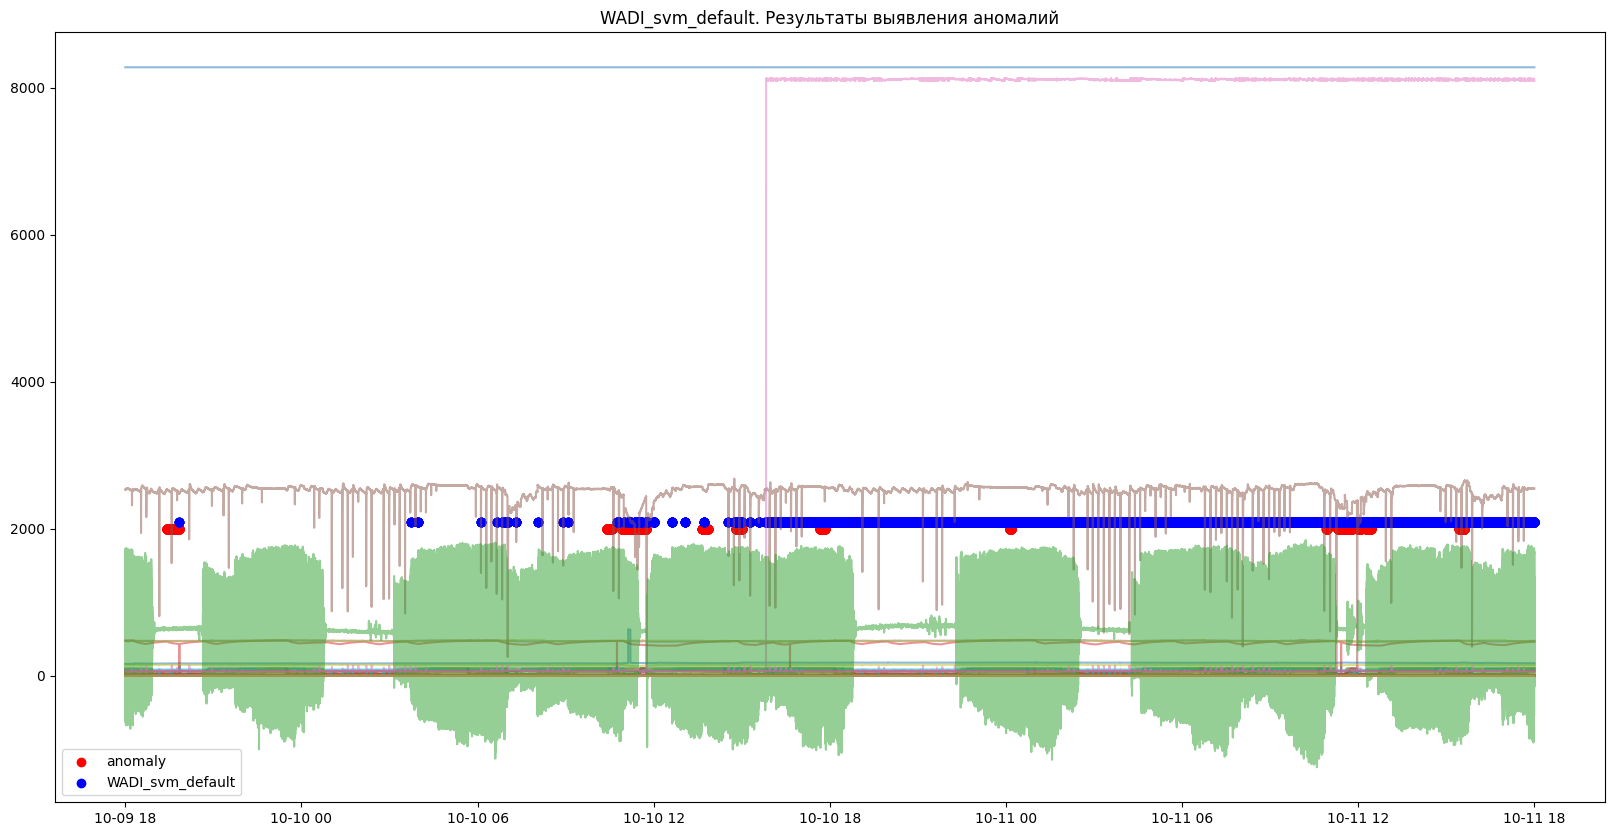

In [20]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Удаление плохих признаков

In [21]:
bad_col

['3_AIT_002_PV', '2B_AIT_002_PV']

In [22]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


2022-08-28 20:39:22.759291: find saved model: ./saved_models/WADI_svm_wo_badcol.joblib, loading...
WADI_svm_wo_badcol
f1_score: 0.39
accuracy_score: 0.95
precision_score: 0.71
recall_score: 0.27


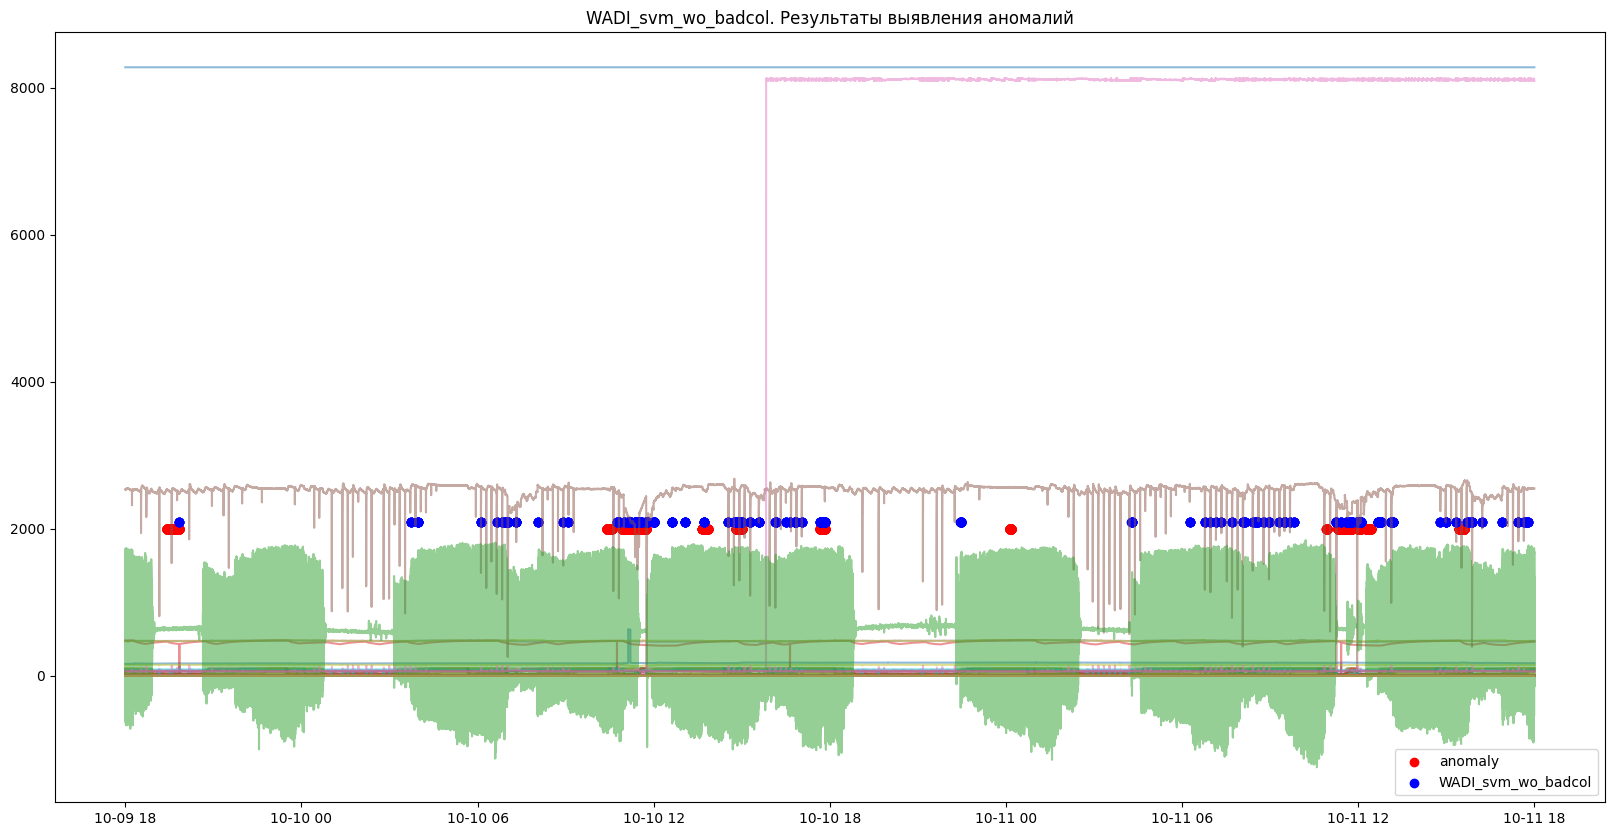

In [23]:
description='WADI_svm_wo_badcol'
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-08-28 20:41:12.284350: find saved model: ./saved_models/WADI_svm_wo_badcol_minmax.joblib, loading...
WADI_svm_wo_badcol_minmax
f1_score: 0.48
accuracy_score: 0.95
precision_score: 0.58
recall_score: 0.42


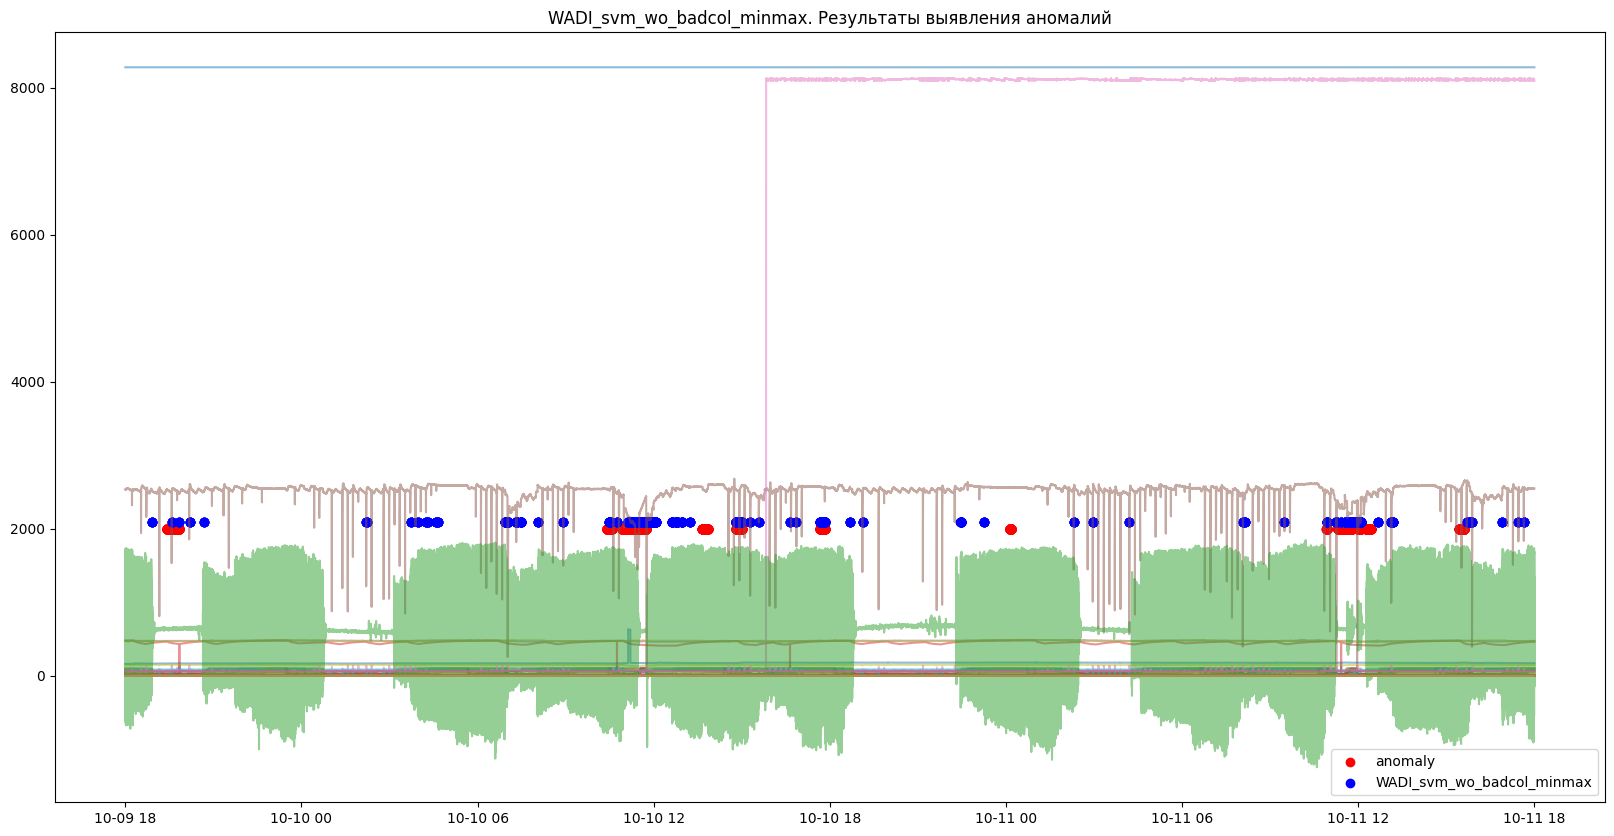

In [24]:
description='WADI_svm_wo_badcol_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [25]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [26]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


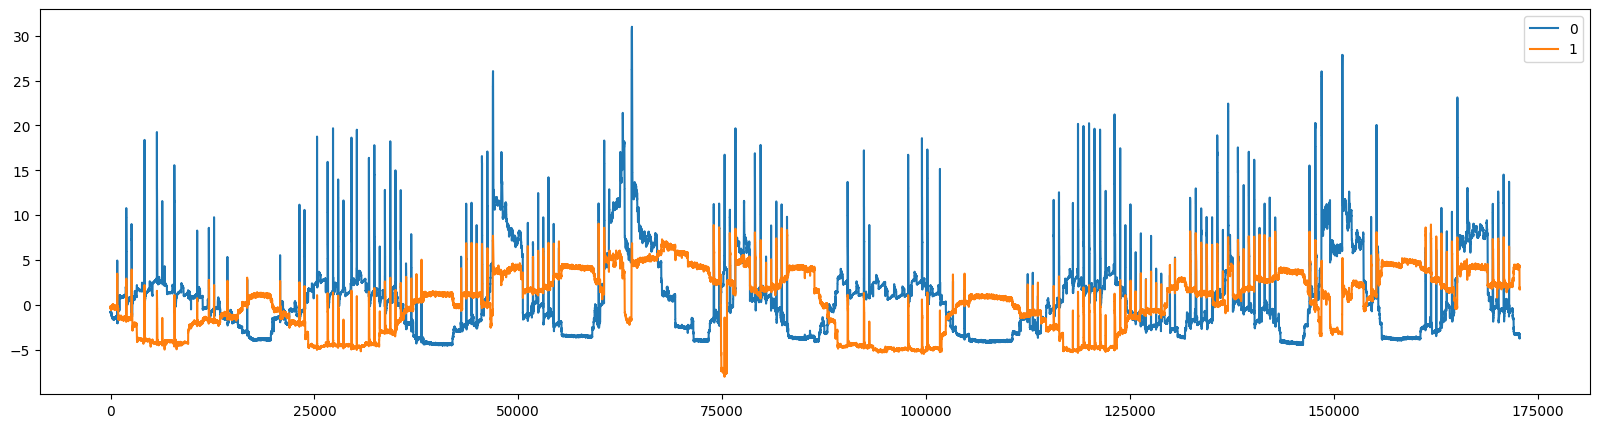

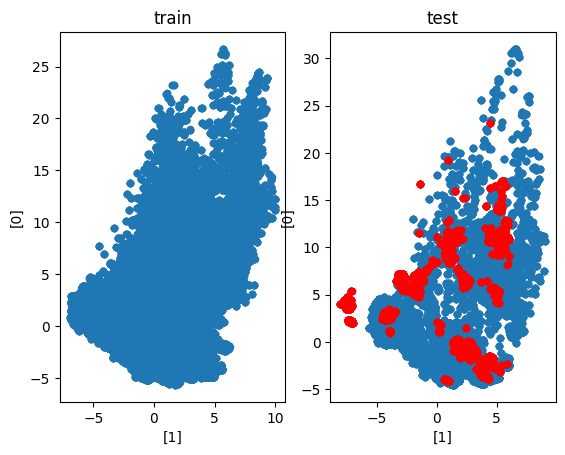

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

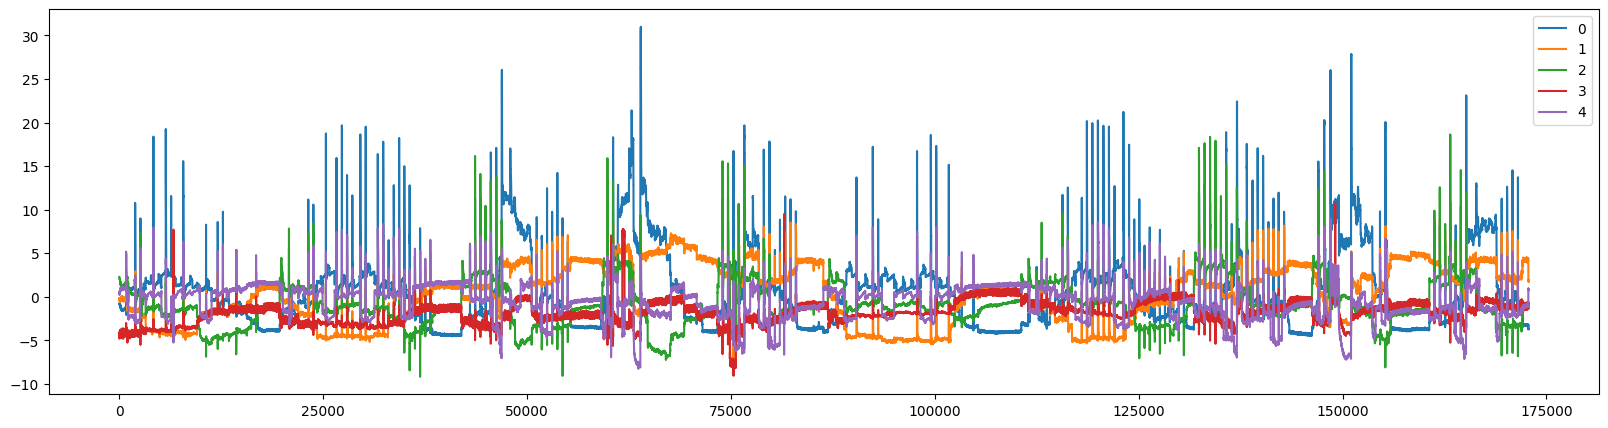

In [28]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [29]:
model = LOF()

2022-08-28 20:43:01.141547: find saved model: ./saved_models/WADI_lof_wo_badcol_n5.joblib, loading...
Train prediction score statistics
            min: -89.34863693139621
            mean: -1.100751834185035
            max: -0.8197120851279738


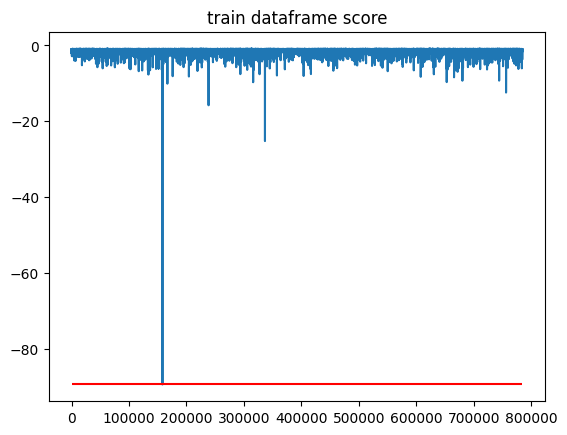

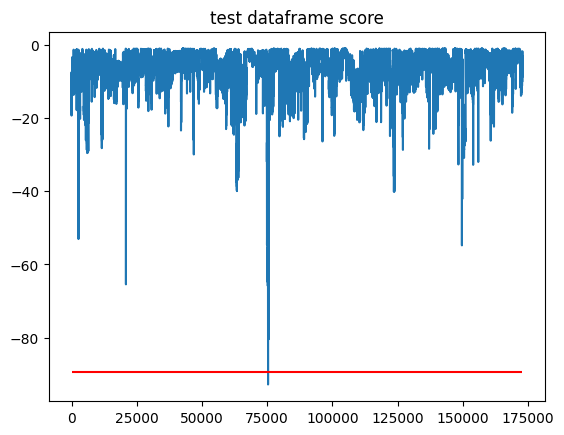

WADI_lof_wo_badcol_n5
f1_score: 0.00
accuracy_score: 0.94
precision_score: 1.00
recall_score: 0.00


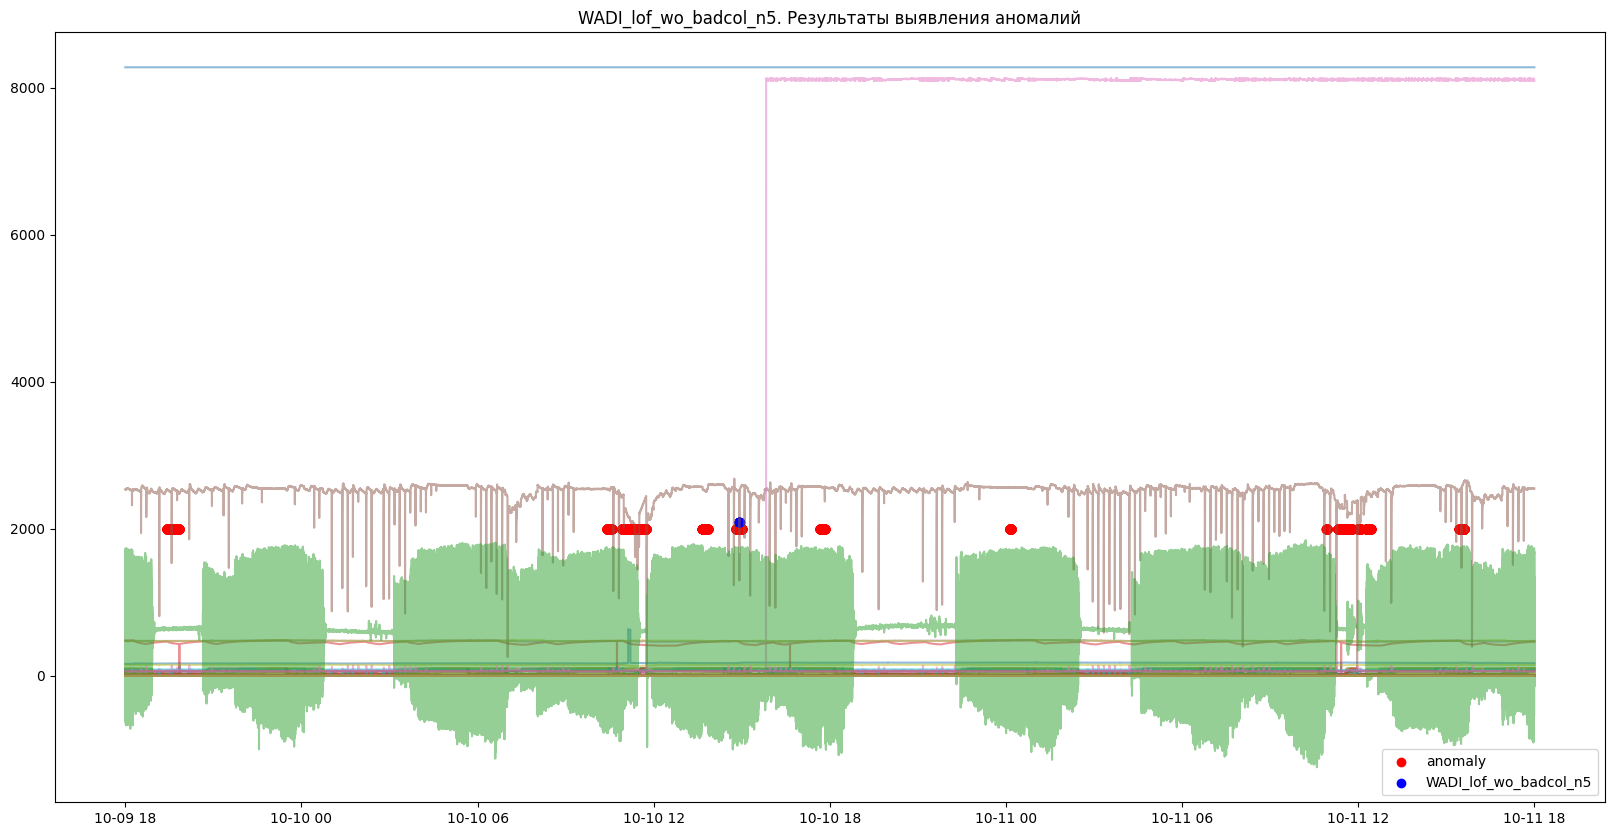

In [30]:
description = f'WADI_lof_wo_badcol_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

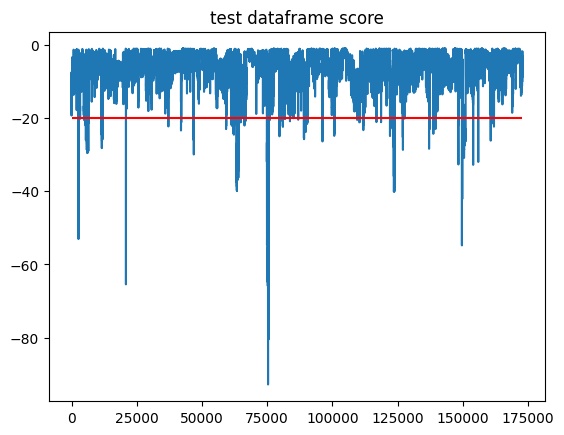

WADI_lof_wo_badcol_n5
f1_score: 0.33
accuracy_score: 0.94
precision_score: 0.52
recall_score: 0.24


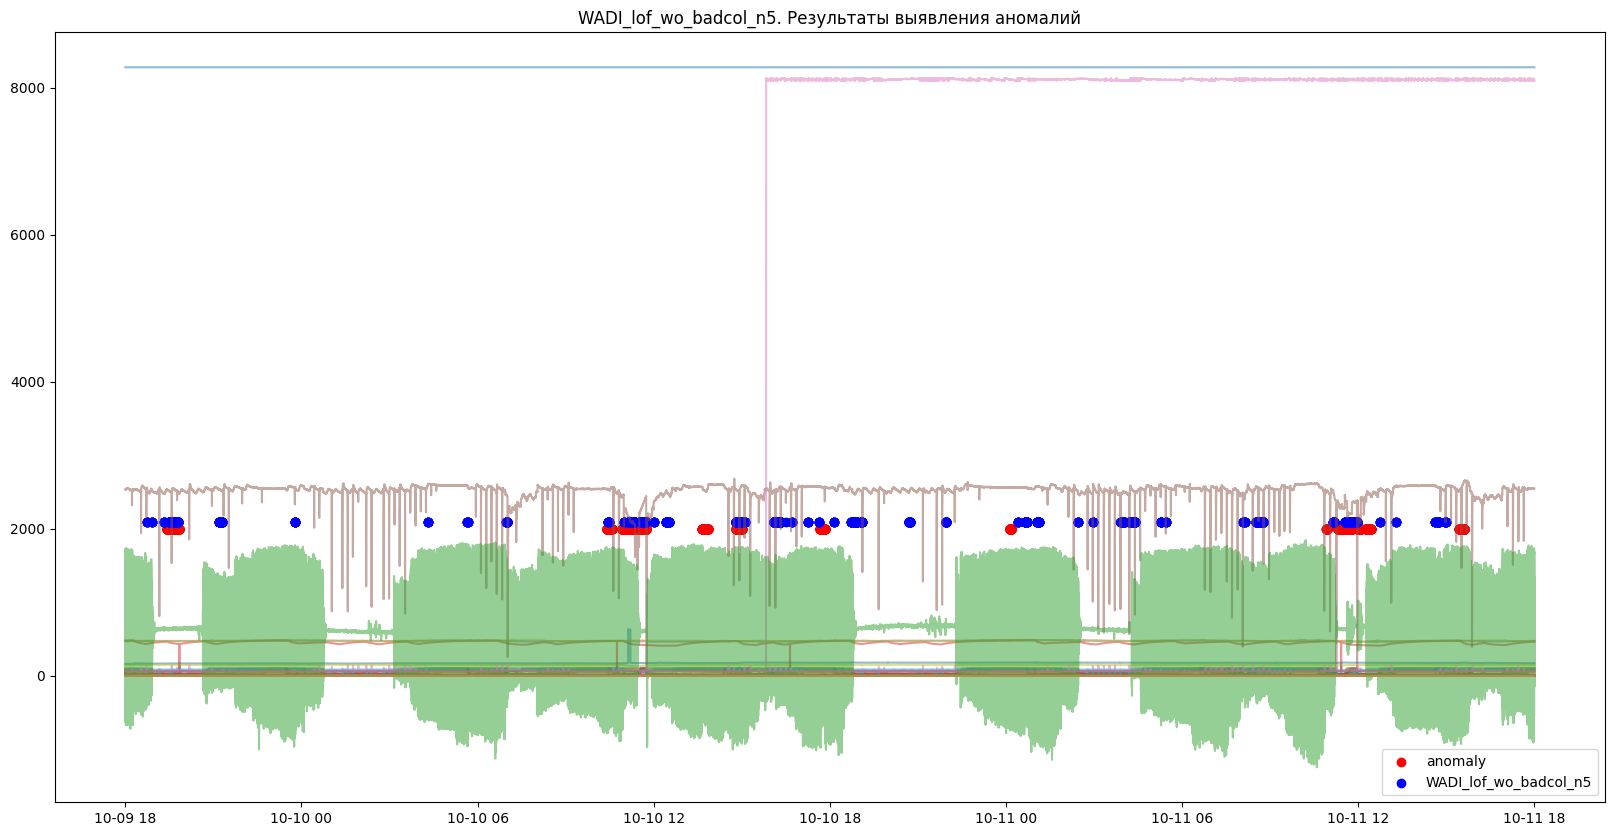

In [31]:
y_pred = predictor.get_anomalies(threshold=-20)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)
2022-08-28 20:44:14.973751: find saved model: ./saved_models/WADI_iF_default.joblib, loading...
WADI_iF_default
f1_score: 0.01
accuracy_score: 0.94
precision_score: 0.06
recall_score: 0.01


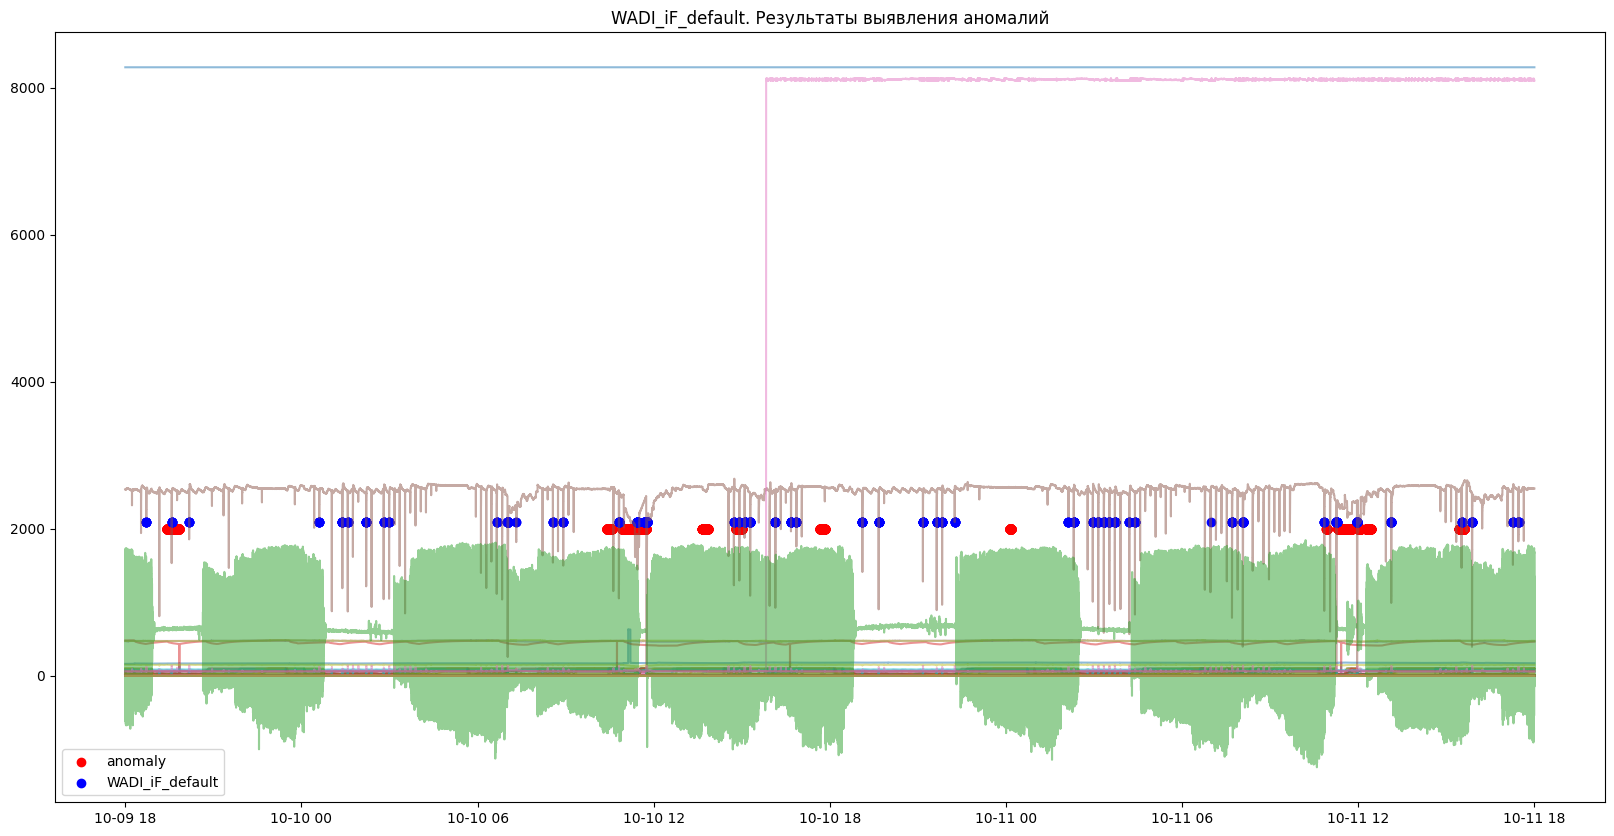

In [32]:
description = f'WADI_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-08-28 20:44:45.353487: find saved model: ./saved_models/WADI_iF_wo_badcol_n_98_c_004.joblib, loading...
WADI_iF_wo_badcol_n_98_c_004
f1_score: 0.15
accuracy_score: 0.94
precision_score: 0.37
recall_score: 0.09


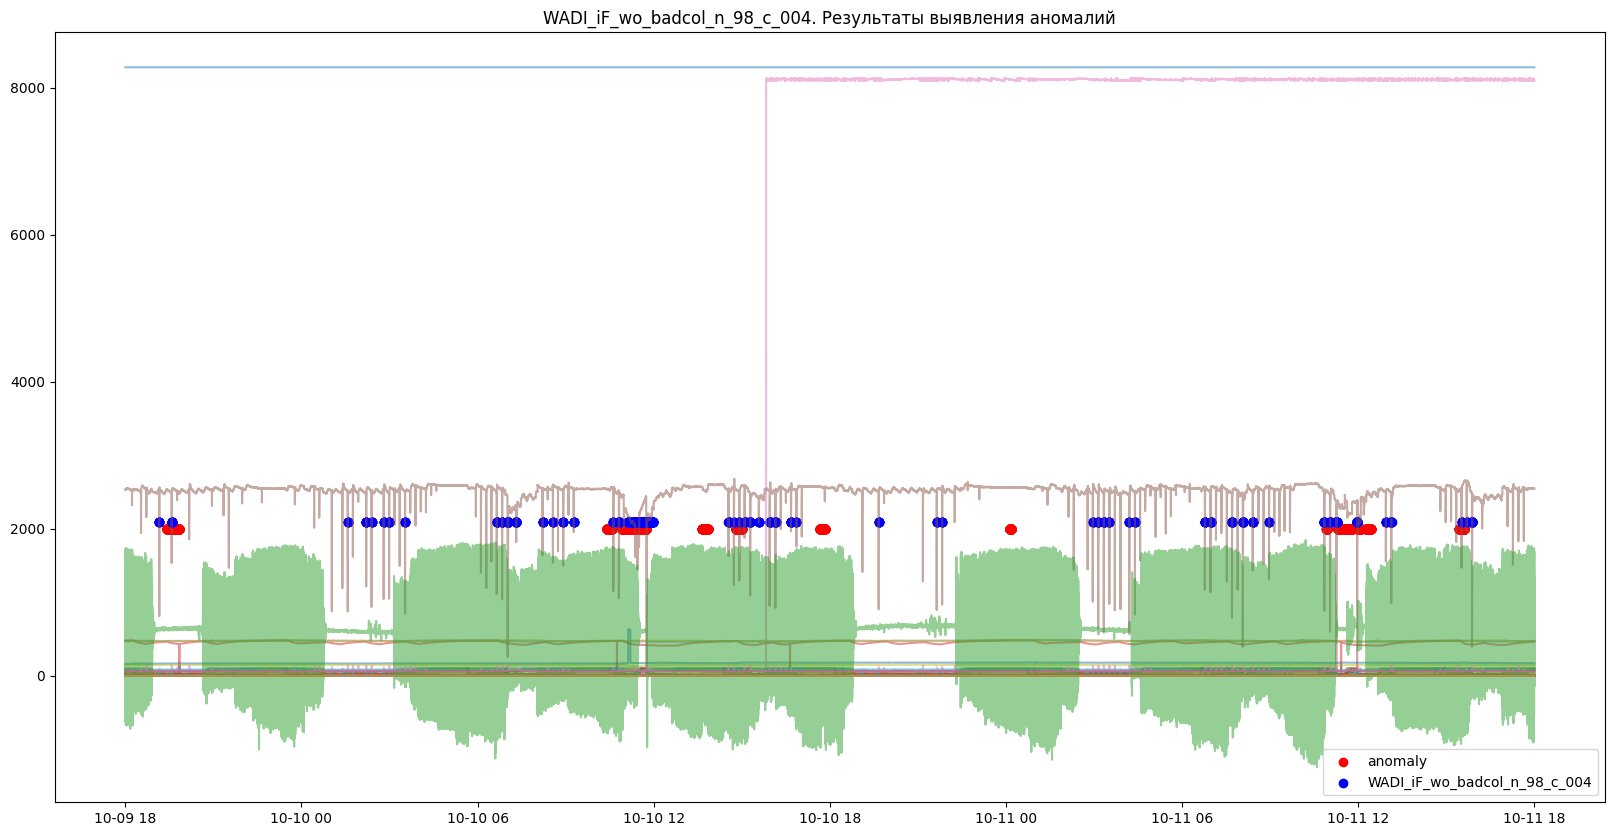

In [33]:
description = f'WADI_iF_wo_badcol_n_98_c_004'

#x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy(), scaler='MinMax')
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

model = iForest(n_estimators=98, contamination=0.004)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (T)
(1667, 98), (2881, 98), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 98)
            x_test: (172792, 10, 98)
            y_test: (172792, 10)
2022-08-28 20:10:59.334945: find saved model: ./saved_models/WADI_ae_lstm_window10_resample_T.joblib, loading...


2022-08-28 20:10:59.329387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 20:10:59.329434: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 20:10:59.329464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-test): /proc/driver/nvidia/version does not exist


3125/3125 [==============================] - 35s 11ms/step
Train prediction score statistics
            min: 5.461921976260358
            mean: 15.285930454849453
            max: 357.1489366832518


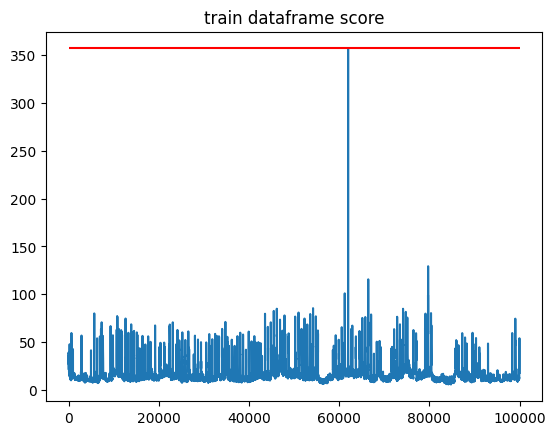

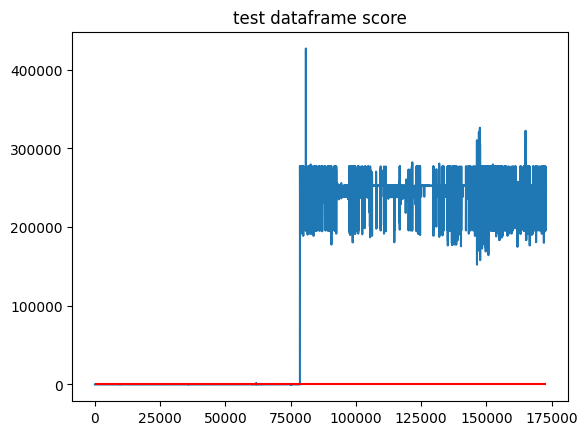

(172792,)
WADI_ae_lstm_window10_resample_T
f1_score: 0.09
accuracy_score: 0.45
precision_score: 0.05
recall_score: 0.45


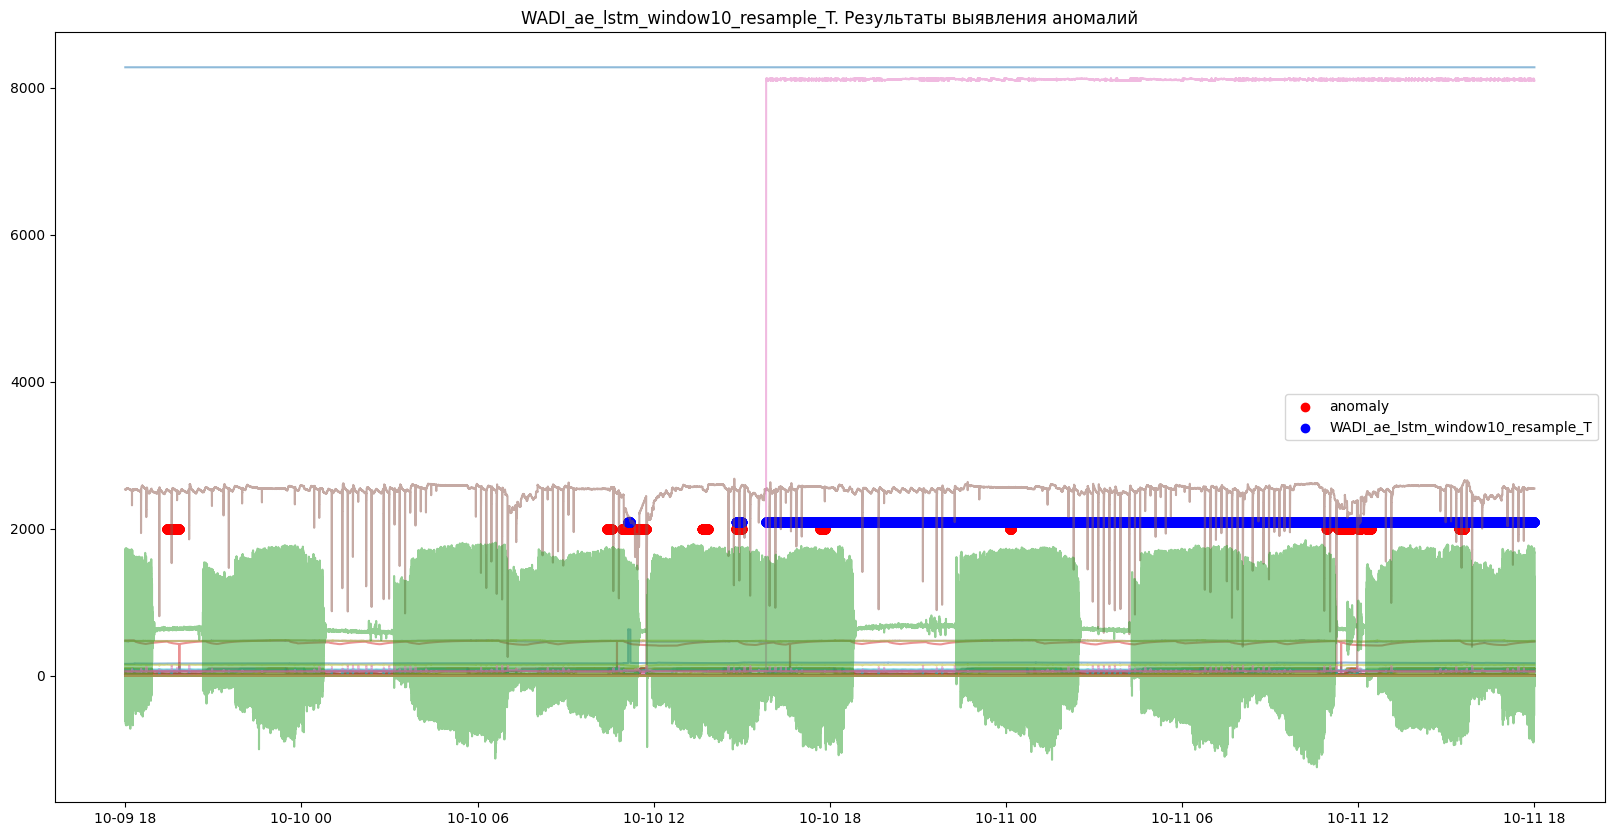

In [10]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_window{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100000].copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [11]:
del x_train, x_test, y_test
del model, predictor

In [12]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_wo_badcol_window{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (T)
(1667, 96), (2881, 96), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 96)
            x_test: (172792, 10, 96)
            y_test: (172792, 10)


2022-08-28 20:13:36.972935: find saved model: ./saved_models/WADI_ae_lstm_wo_badcol_window10_resample_T.joblib, loading...
5400/5400 [==============================] - 60s 11ms/step


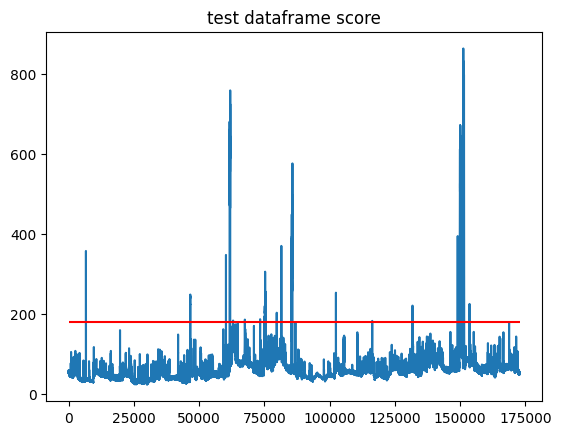

(172792,)
WADI_ae_lstm_wo_badcol_window10_resample_T
f1_score: 0.36
accuracy_score: 0.95
precision_score: 0.94
recall_score: 0.23


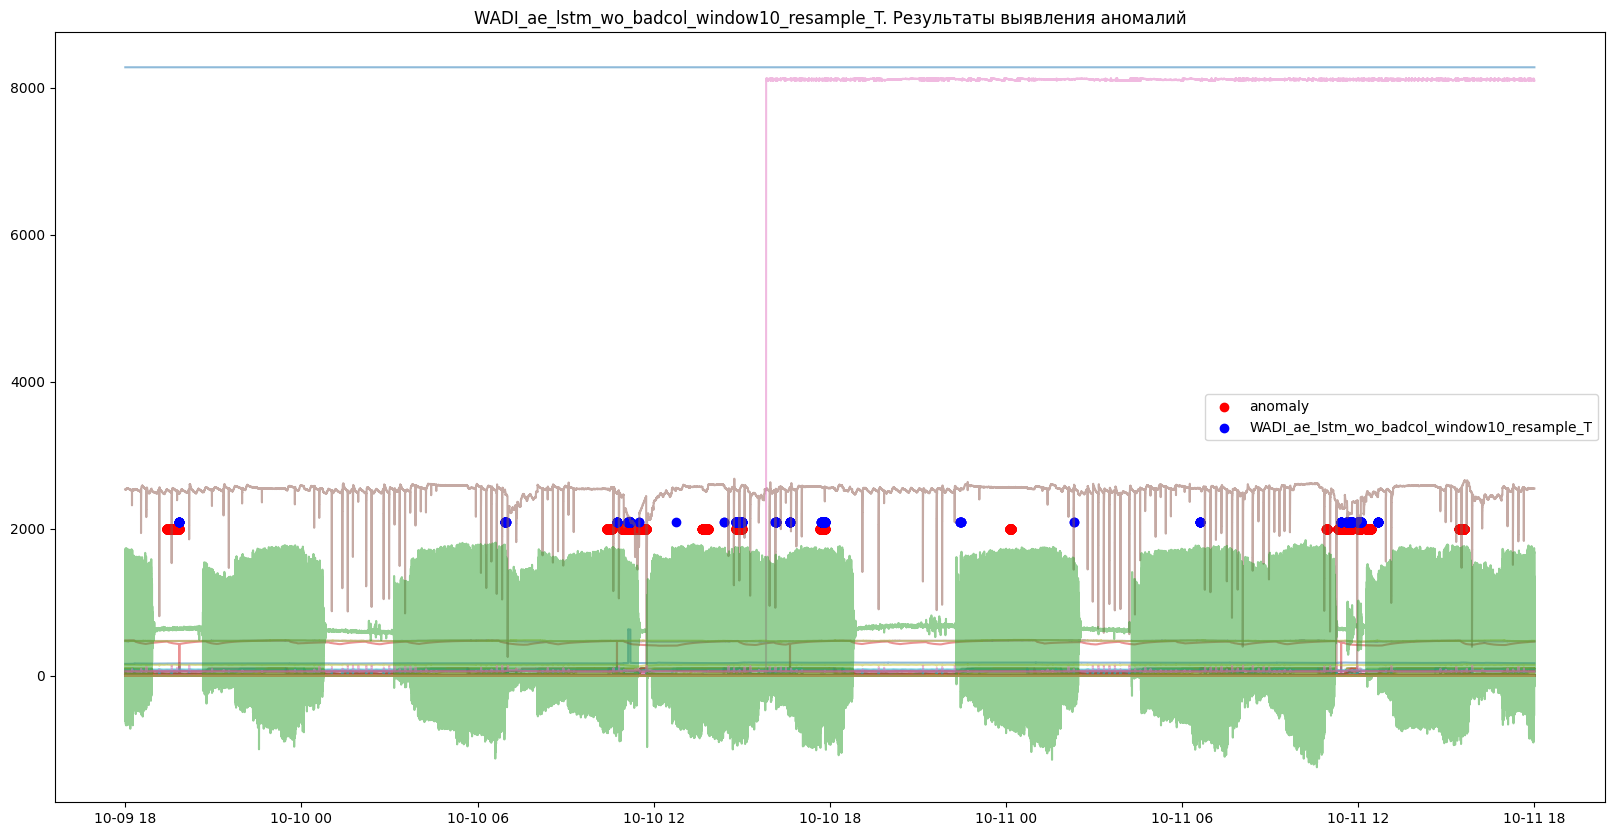

In [13]:
model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies(threshold=180)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [ ]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_wo_badcol_window{window_size}_resample_{resample_rate}_minmax'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate,
                                        scaler='MinMax')

In [ ]:
model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

3125/3125 [==============================] - 29s 9ms/step
Train prediction score statistics
            min: 1.4133974393312352
            mean: 3.467315428295647
            max: 14.258832502551531


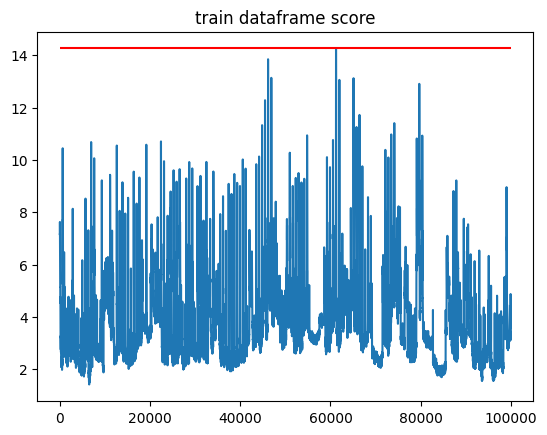

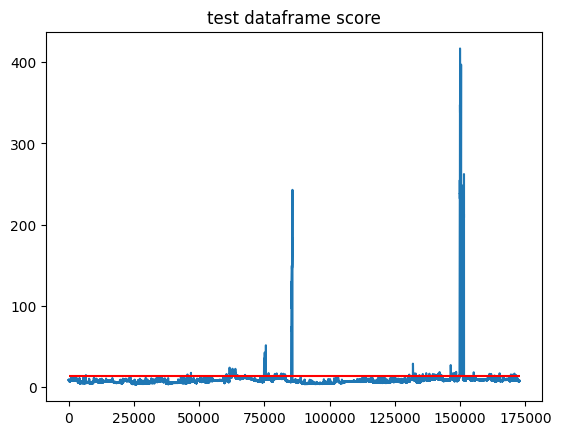

(172792,)
WADI_ae_lstm_wo_badcol_window10_resample_T_minmax
f1_score: 0.43
accuracy_score: 0.95
precision_score: 0.60
recall_score: 0.34


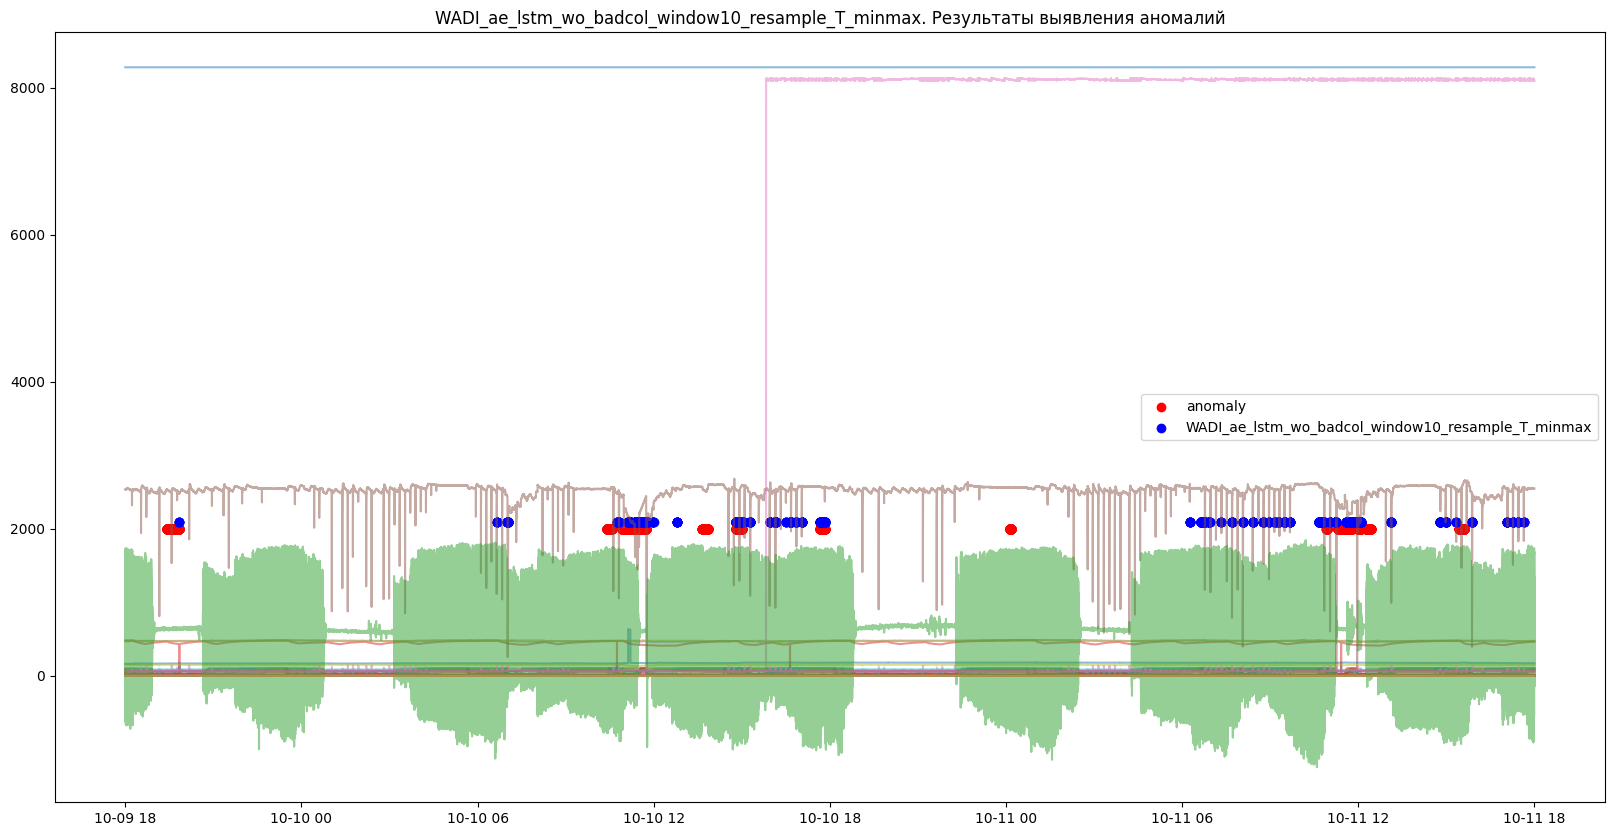

In [36]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## SOM

In [14]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


2022-08-28 20:15:47.345176: find saved model: ./saved_models/WADI_som_default.joblib, loading...


IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

Train prediction score statistics
            min: 5.057284499575796
            mean: 215.24358614284975
            max: 722.0255789647426


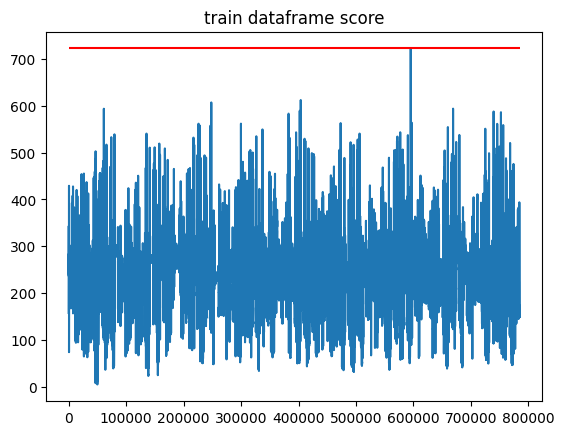

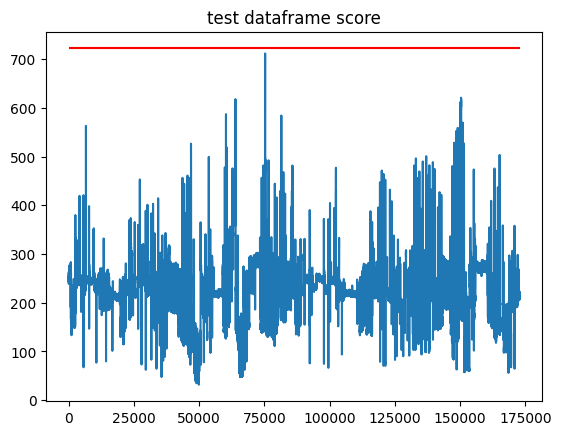

(172801,)
WADI_som_default
f1_score: 0.00
accuracy_score: 0.94
precision_score: 0.00
recall_score: 0.00


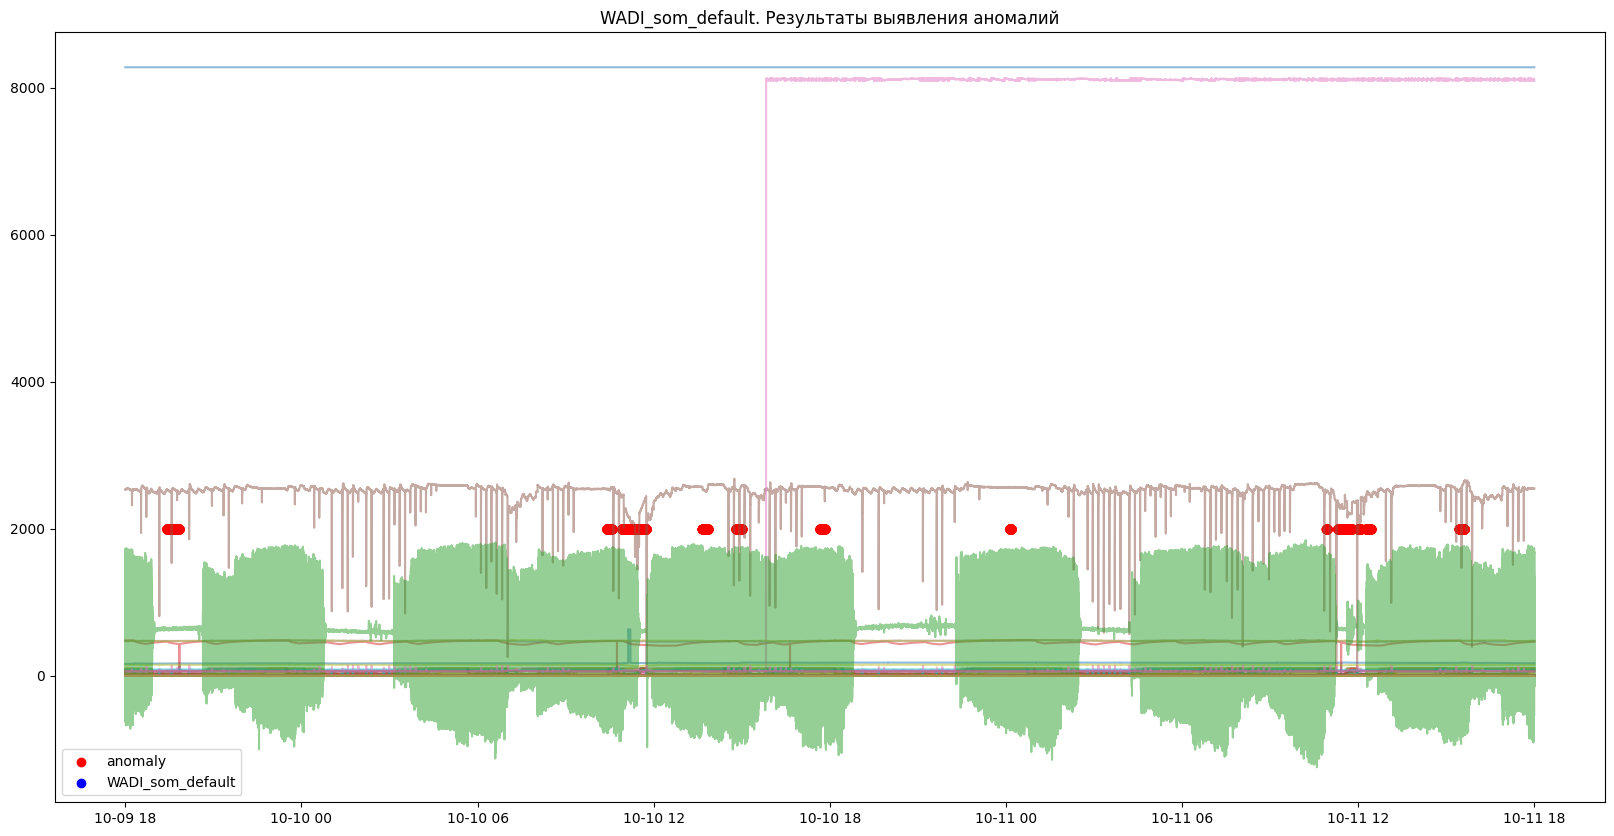

In [15]:
description = f'WADI_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

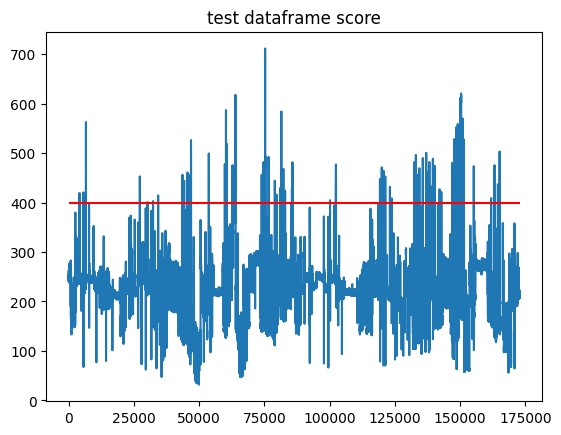

(172801,)
WADI_som_default
f1_score: 0.28
accuracy_score: 0.95
precision_score: 0.65
recall_score: 0.18


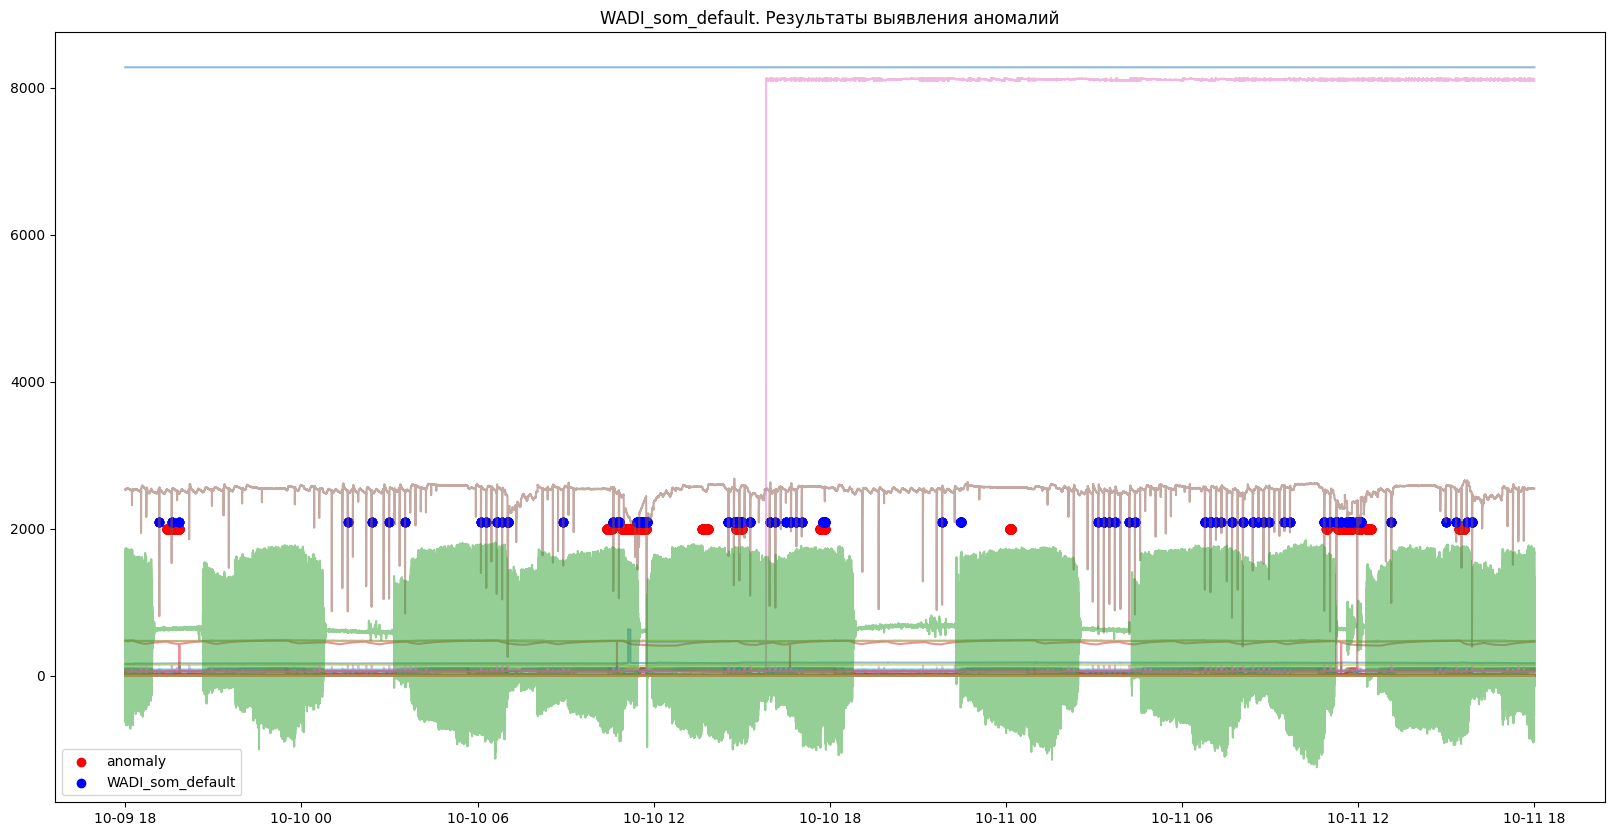

In [16]:
y_pred = predictor.get_anomalies(threshold=400)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

# Сводная таблица

In [48]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
#df_summary.style.format(precision=2).apply(highlight_max, props='color:white;background-color:darkblue', axis=0)
df_summary.style.format(precision=2).background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
WADI_ae_lstm_window10_resample_T,0.09,0.45,0.05,0.45
WADI_ae_lstm_wo_badcol_window10_resample_T,0.36,0.95,0.94,0.23
WADI_som_default,0.28,0.95,0.65,0.18
WADI_svm_default,0.10,0.45,0.05,0.51
WADI_svm_wo_badcol,0.39,0.95,0.71,0.27
WADI_svm_wo_badcol_minmax,0.48,0.95,0.58,0.42
WADI_lof_wo_badcol_n5,0.33,0.94,0.52,0.24
WADI_iF_default,0.01,0.94,0.06,0.01
WADI_iF_wo_badcol_n_98_c_004,0.15,0.94,0.37,0.09
WADI_ae_lstm_wo_badcol_window10_resample_T_minmax,0.43,0.95,0.60,0.34
